# Plot drift across sessions

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import labdatatools as ldt
import spks
from pathlib import Path
from tqdm import tqdm

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 18})

## 1. Get the data from GDrive

In [21]:
SUBJECT = 'JC131'
#DATATYPE = 'kilosort2.5-motion-corrected'
DATATYPE = 'kilosort2.5'
DPATH = Path(r'X:/labdatatools_data/')

files = ldt.rclone_list_files(SUBJECT)
files.head()

ori_sessions = files[files.datatype == 'orientation'].session
ori_sessions = np.unique(ori_sessions).tolist()

temp = []
for sess in ori_sessions: # ensure that kilosort data exists
    if DATATYPE in files[files.session == sess].datatype.values:
        ses = files[files.session == sess].iloc[0].session
        temp.append(ses)
ori_sessions = np.array(temp)
print(len(ori_sessions))

78


In [22]:
ori_sessions = ori_sessions[:5] #truncate for testing

In [23]:
#for date in ori_sessions:
#    ldt.rclone_get_data(subject=SUBJECT, session=date, datatype=DATATYPE, excludes=['**.bin']) #spike sorting
#    ldt.rclone_get_data(subject=SUBJECT, session=date, includes=['**imec*.ap.meta'], excludes=['**.bin']) #meta files

In [24]:
# need to drop sessions with a different channelmap
from spks import *

coords = None
keep_idx = []
metapaths = []
for i,date in enumerate(ori_sessions):
    metapath = Path(ldt.get_filepath(subject=SUBJECT, session=date, subfolders=['ephys_*','*'], filename='*imec*.ap.meta'))
    print(metapath)
    meta = read_spikeglx_meta(metapath)
    if coords is None:
        coords = meta['coords']
    if np.array_equal(coords, meta['coords']):
        keep_idx.append(i)
        metapaths.append(metapath)
    else:
        print(f'Dropping {ori_sessions[i]} due to different channelmap')

#TODO: discard session from december cuz it's so far away? 20231207_174614

ori_sessions = ori_sessions[keep_idx]
    

X:\labdatatools_data\JC131\20230724_175348\ephys_g0\ephys_g0_imec0\ephys_g0_t0.imec0.ap.meta
X:\labdatatools_data\JC131\20230725_211136\ephys_g0\ephys_g0_imec0\ephys_g0_t0.imec0.ap.meta
X:\labdatatools_data\JC131\20230726_184457\ephys_g0\ephys_g0_imec0\ephys_g0_t0.imec0.ap.meta
X:\labdatatools_data\JC131\20230727_183817\ephys_g0\ephys_g0_imec0\ephys_g0_t0.imec0.ap.meta
X:\labdatatools_data\JC131\20230727_190139\ephys_g1\ephys_g1_imec0\ephys_g1_t0.imec0.ap.meta
Dropping 20230727_190139 due to different channelmap


## 2. Load spike positions, amplitudes, and depths

In [25]:
def get_all_spikes(kilosort_paths,
                   ap_meta_paths,
                   shank_num,
                   mindepth=None,
                   maxdepth=None,
                   spike_fraction=None,
                   t_start_sec=0,
                   t_end_sec=None):
    amps,depths,times = [],[],[]
    session_breaks = []
    fileoffset_seconds = 0 # no offset for first session
    for i,(p,metapath) in enumerate(zip(kilosort_paths, ap_meta_paths)):
        print(p)
        #clu = Clusters(p, get_metrics=False, get_waveforms=False)
        #clu.load_waveforms(reload=True)
        #clu.compute_statistics(recompute=True)
        clu = Clusters(p, load_template_features=True)
        #clu.compute_template_amplitudes_and_depths()
        meta = read_spikeglx_meta(metapath)

        depth = clu.spike_positions[:,1]
        amp = np.abs(clu.spike_amplitudes)
        spike_times = clu.spike_times / meta['sRateHz']
        cluster_ids_on_desired_shank = clu.cluster_info[clu.cluster_info.shank == shank_num].cluster_id.values
        spikes_on_desired_shank = np.isin(clu.spike_clusters, cluster_ids_on_desired_shank)

        valid_time_indices = spike_times >= t_start_sec
        spike_times = spike_times[valid_time_indices]
        amp = amp[valid_time_indices]
        depth = depth[valid_time_indices]
        spikes_on_desired_shank = spikes_on_desired_shank[valid_time_indices]

        if t_end_sec is not None:
            valid_time_indices = spike_times <= t_end_sec
            spike_times = spike_times[valid_time_indices]
            amp = amp[valid_time_indices]
            depth = depth[valid_time_indices] 
            spikes_on_desired_shank = spikes_on_desired_shank[valid_time_indices]
        
        spike_times -= t_start_sec # make spike times start at zero
        spike_times += fileoffset_seconds # apply running offset for each file

        amp = amp[spikes_on_desired_shank]
        depth = depth[spikes_on_desired_shank]
        spike_times = spike_times[spikes_on_desired_shank]

        #not_noise  = (clu.cluster_info.active_channels)<40  #TODO: do something to throw out noise spikes?

        if maxdepth is not None:
            amp = amp[depth < maxdepth]
            spike_times = spike_times[depth < maxdepth]
            depth = depth[depth < maxdepth]

        if mindepth is not None:
            amp = amp[depth > mindepth]
            spike_times = spike_times[depth > mindepth]
            depth = depth[depth > mindepth]

        if spike_fraction is not None:
            subselect_inds = np.random.choice(np.arange(len(amps)), len(amps) // spike_fraction, replace=False)
            amp = amp[subselect_inds]
            spike_times = spike_times[subselect_inds]
            depth = depth[subselect_inds]

        amps.extend(amp)
        depths.extend(depth)
        times.extend(spike_times)

        fileoffset_seconds = spike_times[-1] + 1e-6
        session_breaks.append(fileoffset_seconds)

    amps = np.stack(amps)
    times = np.stack(times)
    depths = np.stack(depths)

    assert amps.shape == depths.shape == times.shape
    return amps, times, depths, session_breaks

In [26]:
def get_all_clusters(kilosort_paths):
    clus = []
    for p in kilosort_paths:
        print(p)
        clus.append(Clusters(p, load_template_features=True))
    return clus

def compute_session_offsets_and_srate(metapaths):
    fileoffset_seconds = 0
    session_breaks = [0]
    srates = []
    for m in metapaths:
        meta = read_spikeglx_meta(m)
        srates.append(meta['sRateHz'])
        fileoffset_seconds += meta['fileTimeSecs']
        session_breaks.append(fileoffset_seconds)
    return session_breaks, srates

def get_subset_of_spikes(clus,
                         srates,
                         shank_num,
                         mindepth=None,
                         maxdepth=None,
                         spike_fraction=None,
                         t_start_sec=0,
                         t_end_sec=None):
    amps, depths, times = [],[],[]
    session_breaks = [0]
    fileoffset_seconds = 0
    for i,c in enumerate(clus):
        depth = c.spike_positions[:,1]
        amp = np.abs(c.spike_amplitudes)
        spike_times = c.spike_times / srates[i]
        cluster_ids_on_desired_shank = c.cluster_info[c.cluster_info.shank == shank_num].cluster_id.values
        spikes_on_desired_shank = np.isin(c.spike_clusters, cluster_ids_on_desired_shank)

        valid_time_indices = spike_times >= t_start_sec
        spike_times = spike_times[valid_time_indices]
        amp = amp[valid_time_indices]
        depth = depth[valid_time_indices]
        spikes_on_desired_shank = spikes_on_desired_shank[valid_time_indices]

        if t_end_sec is not None:
            valid_time_indices = spike_times <= t_end_sec
            spike_times = spike_times[valid_time_indices]
            amp = amp[valid_time_indices]
            depth = depth[valid_time_indices]
            spikes_on_desired_shank = spikes_on_desired_shank[valid_time_indices]
        
        spike_times = spike_times - t_start_sec # make spike times start at zero
        spike_times += fileoffset_seconds


        amp = amp[spikes_on_desired_shank]
        depth = depth[spikes_on_desired_shank]
        spike_times = spike_times[spikes_on_desired_shank]

        #not_noise  = (clu.cluster_info.active_channels)<40  #TODO: do something to throw out noise spikes?

        if maxdepth is not None:
            amp = amp[depth < maxdepth]
            spike_times = spike_times[depth < maxdepth]
            depth = depth[depth < maxdepth]

        if mindepth is not None:
            amp = amp[depth > mindepth]
            spike_times = spike_times[depth > mindepth]
            depth = depth[depth > mindepth]

        if spike_fraction is not None:
            subselect_inds = np.random.choice(np.arange(len(amps)), len(amps) // spike_fraction, replace=False)
            amp = amp[subselect_inds]
            spike_times = spike_times[subselect_inds]
            depth = depth[subselect_inds]

        amps.extend(amp)
        depths.extend(depth)
        times.extend(spike_times)

        fileoffset_seconds = spike_times[-1] + 1e-6
        session_breaks.append(fileoffset_seconds)


    amps = np.stack(amps)
    times = np.stack(times)
    depths = np.stack(depths)

    assert amps.shape == depths.shape == times.shape
    return amps, times, depths, session_breaks

In [38]:
# method 1: more memory intense
kilosort_paths = [DPATH / SUBJECT / date / DATATYPE / 'imec0' for date in ori_sessions]

clus = get_all_clusters(kilosort_paths)
session_breaks, srates = compute_session_offsets_and_srate(metapaths)
amps, times, depths, session_breaks = get_subset_of_spikes(clus, srates, 0, mindepth=3000, t_start_sec=60, t_end_sec=300)

X:\labdatatools_data\JC131\20230724_175348\kilosort2.5\imec0
X:\labdatatools_data\JC131\20230725_211136\kilosort2.5\imec0
X:\labdatatools_data\JC131\20230726_184457\kilosort2.5\imec0
X:\labdatatools_data\JC131\20230727_183817\kilosort2.5\imec0


In [41]:
## method 2: slower
#kilosort_paths = [DPATH / SUBJECT / date / DATATYPE / 'imec0' for date in ori_sessions]
#SHANK = 0
#amps, times, depths, session_breaks = get_all_spikes(kilosort_paths, metapaths, SHANK, mindepth=3000, t_start_sec=60, t_end_sec=300)

## 3. Run motion estimation

In [39]:
from dredge.dredge_ap import register
motion_est, _ = register(amps, depths, times)

Cross correlation:   0%|          | 0/1 [00:00<?, ?it/s]

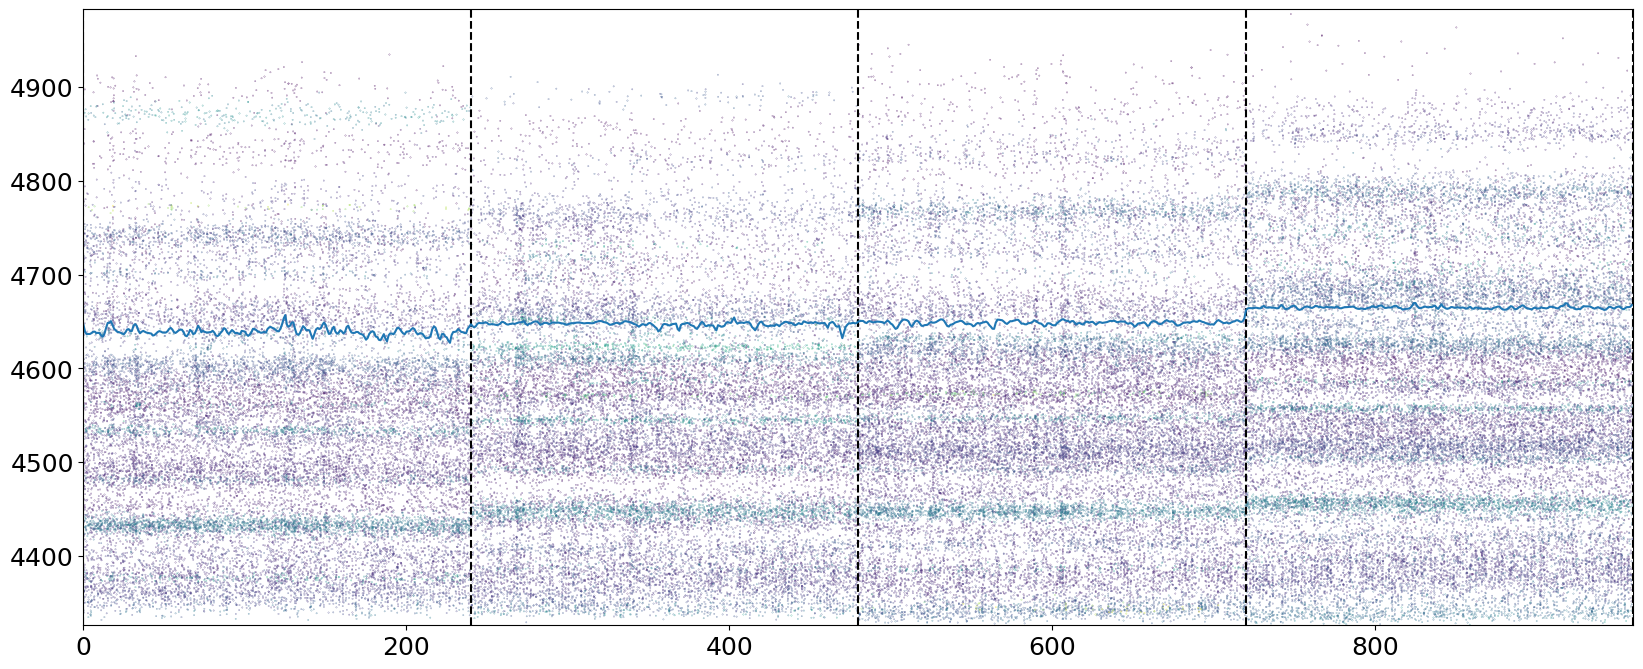

In [40]:
from spks.viz import plot_drift_raster
plt.figure(figsize=(20,8))
plot_drift_raster(times, depths, amps)
plt.vlines(session_breaks, *plt.gca().get_ylim(), linestyles='--', colors='black')
#plt.plot(motion_est.spatial_bin_centers_um + motion_est.displacement.T)
plt.plot(4650 + motion_est.displacement.T)

In [33]:
kilosort_paths = [DPATH / SUBJECT / date / DATATYPE / 'imec0' for date in ori_sessions]

for shank in [0,1,2,3]:
    amps, times, depths, session_breaks = get_all_spikes(kilosort_paths, metapaths, shank, mindepth=3000) # cortex
    motion_est, extra_info = register(amps, times, depths)

    amps, times, depths, session_breaks = get_all_spikes(kilosort_paths, metapaths, shank, maxdepth=None) # thalamus
    motion_est, extra_info = register(amps, times, depths)

X:\labdatatools_data\JC131\20230724_175348\kilosort2.5\imec0


KeyboardInterrupt: 